<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Outlier Analysis</b></p>
</header>
<hr>

<br>
<b style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Introduction:</b>
<p style = 'font-size:16px;font-family:Arial'>An outlier is a data point that is significantly different from other data points in a dataset. Outlier removal is important because outliers can skew the overall analysis and conclusions drawn from a dataset, leading to inaccurate results. By removing outliers, the data can better represent the majority of the dataset and improve the accuracy of the analysis.</p>

<!-- <p style = 'font-size:16px;font-family:Arial'>In the typical process for creating Machine Learning models, a significant amount of time is spent on data preparation and feature selection.  Data scientists and engineers will typically copy data to a tool of choice or data virtualization to perform these tasks.  Moving this data to these tools is impossible at a sufficient scale reflecting typical production volumes.  Even if we can transfer data to another system, the resource requirements to process and analyze this data becomes prohibitively large or expensive.</p>
 -->
<p style = 'font-size:16px;font-family:Arial'>The following demonstration will illustrate using native Vantage SQL functions that can provide greater efficiency, ease of use, and the ability to process data at an extreme scale.  Additionally, a new SQL function <b>TD_ColumnTransformer</b> can create a single, efficient data transformation pipeline.</p>

<p style = 'font-size:16px;font-family:Arial'>The data for this demonstration consists of New York City taxi trip data and includes 500,000 rows with fare amount, passenger count, and pickup and dropoff latitude/longitude.  The demonstration illustrates various functions for data exploration and outlier removal.  The steps in this demo are as follows:</p>

<ol style = 'font-size:16px;font-family:Arial'>
    <li>Perform statistical analysis on the whole data set</li>
    <li>Identify outliers and abnormal data distribution</li>
    <li>Remove outliers and review data</li>
    <li>Perform Bin Coding and Column Transformation to combine Feature Engineering steps</li>
    </ol>

<img src = 'images/Flow_Diagram_Outlier.png' width=100%>

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>1. Connect to Vantage</b>
<p style = 'font-size:16px;font-family:Arial'>You will be prompted to provide the password. Enter your password, press Enter, then use down arrow to go to next cell.</p>

In [1]:
%connect local, hidewarnings=true

Password: ········


Success: 'local' connection established and activated for user 'demo_user', with default database 'demo_user'


<p style = 'font-size:16px;font-family:Arial'>Setup for execution of notebook. Begin running steps with Shift + Enter keys.</p>


In [2]:
SET query_band='DEMO=Outlier_Analysis_Transformation.ipynb;' update for session;

Success: 1 rows affected

<b style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Getting Data for This Demo</b>
<p style = 'font-size:16px;font-family:Arial'>We have provided data for this demo on cloud storage.  You have the option of either running the demo using foreign tables to access the data without using any storage on your environment or downloading the data to local storage which may yield somewhat faster execution, but there could be considerations of available storage.  There are two statements in the following cell, and one is commented out.  You may switch which mode you choose by changing the comment string. 


In [3]:
-- CALL get_data('DEMO_NYCTaxi_cloud');    -- takes about 25 seconds, estimated space: 0 MB
CALL get_data('DEMO_NYCTaxi_local');     -- takes about 1 minute 20 seconds, estimated space: 70 MB

Success: 0 rows affected

Success: 0 rows affected

,Message
1,That ran for 0:00:53.76 with 15 statements and 0 errors.


<p style = 'font-size:16px;font-family:Arial'>Optional step – if you want to see status of databases/tables created and space used.</p>


In [4]:
CALL space_report();  -- optional, takes about 10 seconds

Success: 0 rows affected

Success: 0 rows affected

,Space_Report
1,"You have: #databases=2 #tables=22 #views=5 You have used 80.2 MB of 27,914.4 MB available - 0.3% ... Space Usage OK"
2,
3,Database Name #tables #views Avail MB Used MB
4,"demo_user 20 3 27,812.9 MB 11.3 MB"
5,DEMO_NYCTaxi 0 2 0.0 MB 0.0 MB
6,DEMO_NYCTaxi_db 2 0 101.4 MB 68.9 MB


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>2. Statistical Analysis</b>

<ol style = 'font-size:16px;font-family:Arial'>
    <li>Inspect the data</li>
    <li>Call TD_UnivariateStatistics function to gather statistics</li>
    <li>Pivot and select outlier stats</li>
    </ol>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>2.1 Inspect the Data</b></p>
<p style = 'font-size:16px;font-family:Arial'>As a warm-up, let us look at the tables in our database DEMO_NYCTaxi.</p>       

In [5]:
SELECT 
    DatabaseName,
    TableName
FROM
    DBC.Tables
WHERE
    DatabaseName = 'DEMO_NYCTaxi'

,DatabaseName,TableName
1,DEMO_NYCTaxi,Trip_Fare
2,DEMO_NYCTaxi,Trip


<p style = 'font-size:16px;font-family:Arial'>The query below shows the number of rows in each of the tables in the database.</p>

In [6]:
SELECT
(
    SELECT COUNT(*)
    FROM DEMO_NYCTaxi.trip
) AS trip,
(
    SELECT COUNT(*)
    FROM DEMO_NYCTaxi.trip_fare
) AS trip_fare;

,trip,trip_fare
1,480535,473151


<p style = 'font-size:16px;font-family:Arial'>Let's look at the sample data from trip and trip_fare tables.</p>

In [7]:
SELECT * FROM DEMO_NYCTaxi.trip SAMPLE 5;

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
1,D93C9B85BF766435B7711C16DA556792,07037577036DFF8546BE3638F4B90541,VTS,1,,2013-11-09 19:08:00.000000,2013-11-09 19:27:00.000000,1,1140,5.59,-73.979134,40.728092,-73.966309,40.789864
2,BE2FECC90EEAEA44A97897BDFB3A14E4,8D54A8FD5FD884D833310168F5E1056F,VTS,1,,2013-11-10 05:38:00.000000,2013-11-10 05:46:00.000000,5,480,2.18,-73.949097,40.828537,-73.952888,40.802887
3,B685F8B1CD40C96AD9C3876B904609B2,2003B45CB4AEB9EEE19D976C61E408A5,VTS,1,,2013-11-10 03:23:00.000000,2013-11-10 03:43:00.000000,1,1200,10.52,-73.97892,40.762482,-73.870979,40.77412
4,83D30B1DDEB63761051E96590CE912D9,1DB1792CA46C5A19729DF7B9A26C3766,CMT,1,N,2013-11-10 17:01:05.000000,2013-11-10 17:05:30.000000,1,264,1.3,-73.985062,40.768986,-73.973625,40.757587
5,B09CBB3A924A4E59F80E41E8DE9AED49,4D74C0974ACFC69FC64F380C53F281E7,VTS,1,,2013-11-10 05:53:00.000000,2013-11-10 06:02:00.000000,5,540,1.51,-73.981056,40.764767,-74.00071,40.758202


In [8]:
SELECT * FROM DEMO_NYCTaxi.trip_fare SAMPLE 5;

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
1,D3185D739F7471BFA3C8AF99912DF870,E68526A7ACA09F05E50EF99992C84F1E,CMT,2013-11-10 07:38:58.000000,CRD,7.5,0,0.5,1.6,0,9.6
2,0B24B84044C6BD495B9B9C704BE18FFF,608D3852BA3D23425D33F9F629E2E4DA,VTS,2013-11-10 18:33:00.000000,CRD,7.5,0.5,0.5,1,0,9.5
3,E1258EF6EBE8C3AE1BDEFBB282E8F51E,C42A51C4FA022B9B5401AFFBA50DAA67,CMT,2013-11-09 20:16:26.000000,CSH,6.5,0.5,0.5,0,0,7.5
4,0A6716952AE1B7B1EB901776A8DB82C8,60EBBCD334EE43E67C35522B24E3B249,VTS,2013-11-10 10:15:00.000000,CRD,7,0,0.5,1.4,0,8.9
5,ED7A06D80D0F51DA041E783E51F113EB,20E7855D86C40A61F611564256A11CC1,VTS,2013-11-10 15:29:00.000000,CRD,52,0,0.5,11.47,5.33,69.3


<p style = 'font-size:16px;font-family:Arial'>We are interested in the following columns from the above tables:</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>pickup_datetime</li>
    <li>passenger_count</li>
    <li>pickup_latitude</li>
    <li>pickup_longitude</li>
    <li>dropoff_latitude</li>
    <li>dropoff_longitude</li>
    <li>total_amount</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'>Hence, we create a table with the interested columns as follows:</p>

In [9]:
CREATE TABLE NYC_FULL_T AS (
    SELECT t.pickup_datetime as pickup_datetime,
    t.passenger_count as passenger_count,
    t.pickup_latitude as pickup_latitude,
    t.pickup_longitude as pickup_longitude,
    t.dropoff_latitude as dropoff_latitude,
    t.dropoff_longitude as dropoff_longitude,
    f.total_amount as fare_amount
FROM "DEMO_NYCTaxi"."trip" t
LEFT JOIN "DEMO_NYCTaxi"."trip_fare" f
    ON f.medallion = t.medallion
    AND f.pickup_datetime = t.pickup_datetime) WITH DATA;

Success: 0 rows affected

In [10]:
SELECT COUNT(*) FROM NYC_FULL_T;
SELECT * FROM NYC_FULL_T SAMPLE 5;

,Count(*)
1,480493


,pickup_datetime,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare_amount
1,2013-11-10 17:50:00.000000,1,40.740761,-73.998184,40.726463,-74.005562,6.5
2,2013-11-09 21:43:00.000000,6,40.750637,-73.987236,40.763126,-73.981262,6.5
3,2013-11-10 16:22:37.000000,1,40.708012,-74.015793,40.742519,-74.004486,11
4,2013-11-10 06:45:00.000000,6,40.745232,-73.976952,40.741669,-73.98597,9
5,2013-11-10 15:59:00.000000,1,40.75449,-73.988075,40.697277,-73.931381,35.3


<p style = 'font-size:16px;font-family:Arial'>The above output shows five rows from the view created in the previous step. The view has 480k+ rows.</p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>2.2 Gather statistics using TD_UnivariateStatistics</b></p>

<p style = 'font-size:16px;font-family:Arial'>Univariate analysis is the simplest form of analyzing data. Its significant purpose is to describe; It takes data, summarizes it, and finds patterns in the data.
    <br>
    <a href = 'https://docs.teradata.com/search/all?query=TD_UnivariateStatistics&content-lang=en-US'>TD_UnivariateStatistics</a> displays descriptive statistics for each specified numeric input table column.
</p>

<p style = 'font-size:16px;font-family:Arial'><b><i>*Note that the next cell might take upto 1 minute to run.</i><b>

In [11]:
CREATE TABLE AllStats_unpivoted AS (
    SELECT *
        FROM TD_UnivariateStatistics (
        ON NYC_FULL_T AS InputTable
        USING
        TargetColumns('fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')
        STATS( 
              'BOTTOM5',
              'COEFFICIENT OF VARIATION',
              'CORRECTED SUM OF SQUARES',
              'MEAN',
              'MEDIAN',
              'MODE',           
              'GEOMETRIC MEAN', 
              'HARMONIC MEAN', 
              'TRIMMED MEAN',
              'KURTOSIS',
              'SKEWNESS',
              'STANDARD ERROR',
              'STANDARD DEVIATION',
              'SUM',
              'POSITIVE VALUES COUNT', 
              'TOP5', 
              'INTERQUARTILE RANGE',
              'NEGATIVE VALUES COUNT',
              'NULL COUNT',
              'RANGE',
              'UNCORRECTED SUM OF SQUARES',
              'UNIQUE ENTITY COUNT',
              'VARIANCE',
              'ZERO VALUES COUNT',
              'PERCENTILES',
              'MINIMUM',
              'MAXIMUM'
        )
        ) AS dt
) WITH DATA;

Success: 0 rows affected

In [12]:
SELECT * FROM AllStats_unpivoted SAMPLE 5;

,ATTRIBUTE,StatName,StatValue
1,fare_amount,SKEWNESS,3.4816900635613797
2,pickup_latitude,MODE,0
3,pickup_longitude,PERCENTILES(25),-73.992554
4,pickup_longitude,TRIMMED MEAN,-73.98185047550923
5,dropoff_longitude,STANDARD DEVIATION,8.892694780521119


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>2.3 Pivot for easier analysis</b></p>
<p style = 'font-size:16px;font-family:Arial'><a href='https://docs.teradata.com/search/all?query=PIVOT&content-lang=en-US'>PIVOT</a> is a relational operator for transforming rows into columns. The function is helpful for reporting purposes, allowing you to aggregate and rotate data to create easy-to-read tables.</p>

In [13]:
REPLACE VIEW AllStats_pivoted AS
    SELECT *
        FROM AllStats_unpivoted
        PIVOT (
            MAX(StatValue) FOR  ATTRIBUTE IN ('fare_amount', 
                                                 'pickup_longitude',  
                                                 'pickup_latitude',
                                                 'dropoff_longitude',
                                                 'dropoff_latitude')
        ) tmp;

Success: 0 rows affected

In [14]:
SELECT * FROM Allstats_pivoted ORDER BY 1;

,StatName,'fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'
1,BOTTOM5(1),2.6,-88.810226,0,-89.452866,0
2,BOTTOM5(2),3,-85.308685,0.74427998,-87.662605,33.076866
3,BOTTOM5(3),3.01,-82.792358,20.445541,-81.642937,33.639912
4,BOTTOM5(4),3.46,-81.642937,30.291594,-79.796814,33.658512
5,BOTTOM5(5),3.5,-80.155426,30.515829,-78.300003,40.366444
6,COEFFICIENT OF VARIATION,0.8407865849380025,-0.1189640465853331,0.1189772824830056,-0.12200410004291205,0.12199706775346573
7,CORRECTED SUM OF SQUARES,7.774925192680965e+07,3.6181581367708035e+07,1.0980557590859763e+07,3.79973171906297e+07,1.1529159383876666e+07
8,GEOMETRIC MEAN,+Inf,NaN,0,NaN,0
9,HARMONIC MEAN,10.469093854269458,0,0,0,0
10,INTERQUARTILE RANGE,9,0.024818999999993707,0.03446199999999777,0.030129000000002293,0.03692200000000412


<p style = 'font-size:16px;font-family:Arial'>The output above shows a cleaner way to look at the various statistics for all the specified columns.</p>

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>3. Outlier Identification</b>

<p style = 'font-size:16px;font-family:Arial'>We can see some extraordinary value outliers in our numeric data based on the statistics gathered above. We can use the <a href='https://docs.teradata.com/search/all?query=TD_HISTOGRAM&content-lang=en-US'>TD_Histogram</a> function to look at the distribution of each data column, which can guide how to remove outliers.</p>
    
<ol style = 'font-size:16px;font-family:Arial'>
    <li>Inspect the distribution stastics</li>
    <li>Use TD_Histogram to view column distributions using calculated binning</li>
    <li>Use TD_Histogram using MinMax table as input</li>
    </ol>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>3.1 Simple SELECT</b></p>

<p style = 'font-size:16px;font-family:Arial'>Filter results out of the Pivoted table of Stats. We are interested in maximum, minimum and percentiles for all the columns.</p>

In [15]:
SELECT *
FROM AllStats_pivoted
WHERE "StatName" LIKE 'PERCENTILES(%)'
    OR  "StatName" IN ('MINIMUM', 'MAXIMUM')
ORDER BY 1;

,StatName,'fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'
1,MAXIMUM,450.01,0,46.435387,0,46.232815
2,MINIMUM,2.6,-88.810226,0,-89.452866,0
3,PERCENTILES(1),4,-74.013451,0,-74.01539663999999,0
4,PERCENTILES(10),6,-74.002739,40.717228,-74.002632,40.709984
5,PERCENTILES(25),8,-73.992554,40.731022,-73.991814,40.73106
6,PERCENTILES(5),5.5,-74.006348,40.7003828,-74.006889,40.683881
7,PERCENTILES(50),11.3,-73.98288,40.75008,-73.980759,40.750927
8,PERCENTILES(75),17,-73.967735,40.765484,-73.961685,40.767982
9,PERCENTILES(90),28.62,-73.950325,40.779202,-73.940895,40.783108
10,PERCENTILES(95),41.25,-73.873322,40.787151,-73.876793,40.795422


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>3.2 Histograms for distribution analysis</b></p>

<p style = 'font-size:16px;font-family:Arial'><a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Advanced-SQL-Engine-Analytic-Functions/April-2022/Data-Exploration-Functions/TD_Histogram'>TD_Histogram</a> calculates the frequency distribution of a data set using your choice from these methods:</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Sturges, which uses w = r/(1 + log2n) for bin width</li>
    <li>Scott, which uses w = 3.49s/(n1/3) for bin width</li>
    <li>Variable-width, which requires a MinMax table</li>   
    <li>Equal-width, which requires a MinMax table</li>
    </ul>

<p style = 'font-size:16px;font-family:Arial'>An example using Sturges is below; note that the algorithmic methods work best on normally distributed data, so in this case, the bin widths illustrate how a few extreme outliers can skew the overall data distribution.</p>

In [16]:
SELECT *
FROM TD_Histogram (
    ON NYC_FULL_T AS InputTable
    USING
    TargetColumn('fare_amount')
    MethodType('Sturges')
) AS dt ORDER BY 1;

,ColumnName,Label,MinValue,MaxValue,CountOfValues,Bin_Percent
1,fare_amount,3,150,200,69,0.014584007051050367
2,fare_amount,8,400,450,1,0.00021136242102971542
3,fare_amount,5,250,300,7,0.001479536947208008
4,fare_amount,2,100,150,387,0.08179725693849987
5,fare_amount,1,50,100,15264,3.2262359945975767
6,fare_amount,9,450,500,1,0.00021136242102971542
7,fare_amount,7,350,400,0,0
8,fare_amount,4,200,250,28,0.005918147788832032
9,fare_amount,6,300,350,4,0.0008454496841188617
10,fare_amount,0,0,50,457360,96.66871688215065


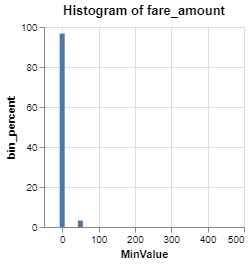

In [17]:
%chart x = MinValue, y = bin_percent, title = "Histogram of fare_amount"

<p style = 'font-size:16px;font-family:Arial'>The results above indicate that <b>96.6%</b> of fares are in the range 0-50. Almost all the data is residing in the 0-100 fare price range.</p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>3.3 Histograms with MinMax table</b></p>

<p style = 'font-size:16px;font-family:Arial'>An alternative method for defining bin width is to use a MinMax table. For fixed-width bins, the MinMax table only needs two columns, "MinValue" and "MaxValue", representing the column's overall min and max values. For variable-width bins, the MinMax table needs an extra "label" column, and each row MinValue and MaxValue will represent the value range of the bin.</p>

<p style = 'font-size:16px;font-family:Arial'>Specifically for the fare amount column, this MinMax table will only bin values from 0 to 100 in the specified range. Visualization of the results yields a much more manageable distribution.</p>

In [18]:
CREATE MULTISET TABLE fare_amount_minmax ( 
    MinValue INTEGER, 
    MaxValue INTEGER,
    Label VARCHAR(10)
);

Success: 0 rows affected

In [19]:
%dataload table=fare_amount_minmax, database=demo_user, filepath=UseCases/Outlier_Analysis/data/EDA_MinMax.csv

Using database: demo_user
2023-07-13T11:54:27.300 Start Batch Loading...
     
Data Load: Number Rows Loaded = 51, Elapsed Time = 00:00:00.403, History ID = 184
Success Loading Data: from file,'/home/jovyan/JupyterLabRoot/UseCases/Outlier_Analysis/data/EDA_MinMax.csv', into table, demo_user.fare_amount_minmax.

In [20]:
SELECT * FROM fare_amount_minmax ORDER BY MinValue;

,MinValue,MaxValue,Label
1,0,2,0-2
2,2,4,2-4
3,4,6,4-6
4,6,8,6-8
5,8,10,8-10
6,10,12,10-12
7,12,14,12-14
8,14,16,14-16
9,16,18,16-18
10,18,20,18-20


<p style = 'font-size:16px;font-family:Arial'>The table fare_amount_minmax has 51 bins of width 2 in the range 0 to 100. We will use this table to create a variable-width histogram. Note that you can change the fare_amount_minmax table to declare bins of any width.</p>

In [21]:
SELECT *
FROM TD_Histogram (
    ON NYC_FULL_T AS InputTable
    ON fare_amount_minmax AS minmax DIMENSION
    USING
    MethodType ('variable-width')
    TargetColumn ('fare_amount')
    nbins(51)
) AS dt ORDER BY 2;

,ColumnName,Label,MinValue,MaxValue,CountOfValues,Bin_Percent
1,fare_amount,0-2,0,2,0,0
2,fare_amount,10-12,10,12,64678,13.670498667359935
3,fare_amount,100,100,100,0,0
4,fare_amount,12-14,12,14,48759,10.305820286987895
5,fare_amount,14-16,14,16,35016,7.401066534776516
6,fare_amount,16-18,16,18,27424,5.796403034318916
7,fare_amount,18-20,18,20,19887,4.203364467017951
8,fare_amount,2-4,2,4,2474,0.522910629627516
9,fare_amount,20-22,20,22,14299,3.0222712583039013
10,fare_amount,22-24,22,24,10916,2.307232187960374


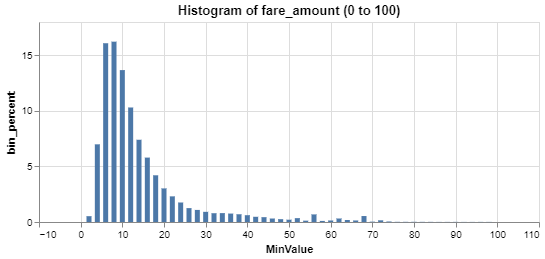

In [22]:
%chart x=MinValue, y=bin_percent, title="Histogram of fare_amount (0 to 100)", width=500

<p style = 'font-size:16px;font-family:Arial'>Now we have a better visualization of the distribution of majority of trips with fare in the range 1 to 100.</p>

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>4. Outlier Removal</b>

<p style = 'font-size:16px;font-family:Arial'>At this point, we've identified that our data has some extreme outliers. The Histogram illustration quantifies this for fare amount, but if we inspect the other columns, we will see similar features in the data.</p>

<p style = 'font-size:16px;font-family:Arial'>TD_OutlierFilterFit and TD_OutlierFilterTransform can selectively modify values or remove rows representing the outlier columns.</p>

<ol style = 'font-size:16px;font-family:Arial'>
    <li>Create a Fit Table using TD_OutlierFilterFit</li>
    <li>Transform the data set using TD_OutlierFilterTransform</li>
    <li>Compare distributions before and after</li>
</ol>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.1 TD_OutlierFilterFit</b></p>

<p style = 'font-size:16px;font-family:Arial'><a href = 'https://docs.teradata.com/search/all?query=TD_OutlierFilterFit&content-lang=en-US'>TD_OutlierFilterFit</a> function calculates the lower_percentile, upper_percentile, count of rows and median for the specified input table columns. The calculated values for each column help the TD_OutlierFilterTransform function detect outliers in the input table.</p>
<p style = 'font-size:16px;font-family:Arial'>Some select parameters include</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>TargetColumns; which takes a list or a range of values/ordinals</li>
    <li>ReplacementValue; delete, null. median, or a value</li>
    <li>OutlierMethod; Percentile, tukey, or carling</li>
    <li>Variable-width, which requires a MinMax table</li>   
    <li>Other outlier identification parameters depending on OutlierMethod</li>
    </ul>

<p style = 'font-size:16px;font-family:Arial'>In this case, we will use the Percentile method on our latitude/longitude on columns to delete rows containing outlier values. Additional parameter values define upper and lower percentile values and the percentile calculation method (Discrete).</p>
<p style = 'font-size:16px;font-family:Arial'><b><i>*Note that the next cell might take upto 1 minute to run.</i><b>

In [23]:
CREATE TABLE OutlierFitTbl AS(
    SELECT *
        FROM TD_OutlierFilterFit(
            ON NYC_FULL_T AS InputTable
            USING
            TargetColumns('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')  
            LowerPercentile(0.02)
            UpperPercentile(0.98)  
            OutlierMethod('Percentile')            
            ReplacementValue('delete')
        ) AS dt
) WITH DATA;

Success: 0 rows affected

In [24]:
SELECT * FROM OutlierFitTbl;

,TD_OUTLIERMETHOD_OFTFIT,TD_IQRMULTIPLIER_OFTFIT,TD_REMOVETAIL_OFTFIT,TD_REPLACEMENTVALUE_OFTFIT,TD_MINTHRESHOLD_OFTFIT,TD_MAXTHRESHOLD_OFTFIT,TD_ATTRIBUTEVALUE_OFTFIT,TD_COUNTVALUE_OFTFIT,TD_MEDIANVALUE_OFTFIT,TD_LOWERPERCENTILE_OFTFIT,TD_UPPERPERCENTILE_OFTFIT
1,PERCENTILE,1.5,BOTH,DELETE,0.02,0.98,dropoff_longitude,480493,-73.980759,-74.011742,-73.783173
2,PERCENTILE,1.5,BOTH,DELETE,0.02,0.98,pickup_longitude,480493,-73.98288,-74.009659,-73.782463
3,PERCENTILE,1.5,BOTH,DELETE,0.02,0.98,dropoff_latitude,480493,40.750927,40.642479,40.812508
4,PERCENTILE,1.5,BOTH,DELETE,0.02,0.98,pickup_latitude,480493,40.75008,40.644638,40.798721


<p style = 'font-size:16px;font-family:Arial'>The above calculated values for each column in the OutlierFitTbl will help in removing outliers from the original data set.</p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.2 TD_OutlierFilterTransform</b></p>

<p style = 'font-size:16px;font-family:Arial'><a href = 'https://docs.teradata.com/search/all?query=TD_OutlierFilterTransform&content-lang=en-USm'>TD_OutlierFilterTransform</a> filters outliers from the input table. The metrics for determining outliers come from TD_OutlierFilterFit output, i.e. OutlierFitTbl in our case.</p>

<p style = 'font-size:16px;font-family:Arial'>Here, we create a View to save on space and allow for before and after comparison. This view has no outliers w.r.t. 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'.</p>

In [25]:
REPLACE VIEW latlong_no_outliers AS (
    SELECT *
        FROM TD_OutlierFilterTransform(
        ON NYC_FULL_T AS InputTable PARTITION BY ANY
        ON OutlierFitTbl AS FitTable DIMENSION 
        ) AS dt
);

Success: 0 rows affected

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.3 Before and After Comparison</b></p>

<p style = 'font-size:16px;font-family:Arial'>Use TD_Histogram to visualize the distributions of data before and after transformation. Use the <b>Pickup Latitude</b> column as a good example.</p>

In [26]:
SELECT *
    FROM TD_Histogram (
    ON NYC_FULL_T  AS InputTable
    USING
    MethodType ('Sturges')
    TargetColumn ('pickup_latitude')
) AS dt ORDER BY 1;

,ColumnName,Label,MinValue,MaxValue,CountOfValues,Bin_Percent
1,pickup_latitude,3,15,20,0,0
2,pickup_latitude,8,40,45,473779,98.60268515878484
3,pickup_latitude,5,25,30,0,0
4,pickup_latitude,2,10,15,0,0
5,pickup_latitude,1,5,10,0,0
6,pickup_latitude,9,45,50,1,0.000208119577184267
7,pickup_latitude,7,35,40,1,0.000208119577184267
8,pickup_latitude,4,20,25,1,0.000208119577184267
9,pickup_latitude,6,30,35,5,0.001040597885921335
10,pickup_latitude,0,0,5,6706,1.3956498845976943


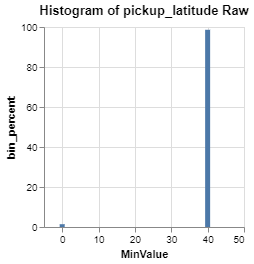

In [27]:
%chart x=MinValue, y=bin_percent, title="Histogram of pickup_latitude Raw"

<p style = 'font-size:16px;font-family:Arial'>This graph shows that a staggering 98.6% of rides were having pickup_lattitude between 40-45. Nearly 1.4% of rides have pickup_latitude outside the 40-45 range. This implies that these are outliers and might give incorrect results if used further in the analysis. These outliers may point to a geographic location that the company doesn't cater to. Hence we should remove these outliers.</p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>After Outlier Removal Comparison</b></p>

<p style = 'font-size:16px;font-family:Arial'>Use the <b>View</b> created above instead of the raw data. We will see a striking difference in the distribution of data.</p>

In [28]:
SELECT *
    FROM TD_Histogram (
    ON latlong_no_outliers AS InputTable
    USING
    MethodType ('Sturges')
    TargetColumn ('pickup_latitude')
) AS dt ORDER BY 1;

,ColumnName,Label,MinValue,MaxValue,CountOfValues,Bin_Percent
1,pickup_latitude,3,40.67,40.68,1813,0.42235671787130347
2,pickup_latitude,8,40.72,40.730000000000004,49444,11.518480727208345
3,pickup_latitude,5,40.69,40.7,2417,0.5630646371180036
4,pickup_latitude,2,40.660000000000004,40.67,524,0.12207110875044845
5,pickup_latitude,1,40.65,40.660000000000004,245,0.05707523214477074
6,pickup_latitude,11,40.75,40.76,70998,16.539703395160952
7,pickup_latitude,13,40.77,40.78,48569,11.314640612405592
8,pickup_latitude,10,40.74,40.75,66785,15.558242362402098
9,pickup_latitude,9,40.730000000000004,40.74,52591,12.251606260104646
10,pickup_latitude,12,40.76,40.77,68370,15.927484170359085


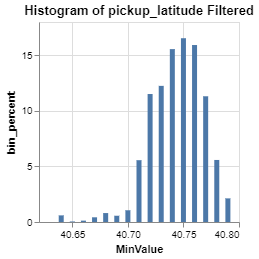

In [29]:
%chart x=MinValue, y=bin_percent, title="Histogram of pickup_latitude Filtered"

<p style = 'font-size:16px;font-family:Arial'>By removing the outliers in the pickup_latitude, we are better able to represent the dataset.</p>

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>5. Bin Coding</b>

<p style = 'font-size:16px;font-family:Arial'>Note that we've only filtered out latitude and longitude outliers and still need to transform the fare amount column, which does have extreme values that need to be addressed.  For this demonstration, we will use TD_BinCodeFit to create a fit table and then use TD_ColumnTransformer to combine the Outlier Filtering and Bin Coding steps into a single statement.</p>

<ol style = 'font-size:16px;font-family:Arial'>
    <li>Inspect the rows with max and min values</li>
    <li>Create a fit table with the value ranges and category labels</li>
    <li>Use TD_ColumnTransformer to create a transformation "Pipeline"</li>
    <li>Compare distributions before and after using TD_CategoricalSummary</li>
    </ol>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.1 Min and Max Values</b></p>

<p style = 'font-size:16px;font-family:Arial'>Use <a href = 'https://docs.teradata.com/search/all?query=TD_WhichMin&content-lang=en-US'>TD_WhichMin</a> and <a href='https://docs.teradata.com/search/all?query=TD_WhichMax&content-lang=en-US'>TD_WhichMax</a> to inspect the rows of the raw data table that contain the min and max values.</p>

In [30]:
SELECT * FROM TD_WhichMin (
   ON NYC_FULL_T AS InputTable
   USING
   TargetColumn('fare_amount')
) AS dt;

,pickup_datetime,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare_amount
1,2013-11-10 09:27:00.000000,1,0,0,0,0,2.6


In [31]:
SELECT * FROM TD_WhichMax (
   ON NYC_FULL_T AS InputTable
   USING
   TargetColumn('fare_amount')
) AS dt;

,pickup_datetime,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare_amount
1,2013-11-10 00:59:05.000000,1,40.779091,-73.985077,40.776436,-73.987083,450.01


<p style = 'font-size:16px;font-family:Arial'>Above are the rows with min fare($2.6) and max fare(\$450).</p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.2 TD_BinCodeFit</b></p>

<p style = 'font-size:16px;font-family:Arial'>Bin coding is typically used to convert numeric data to categorical data by binning the numeric data into multiple numeric bins (intervals). The bins can have a fixed width with auto-generated labels or specified variable widths and labels.</p>

<p style = 'font-size:16px;font-family:Arial'><a href = 'https://docs.teradata.com/search/all?query=TD_BinCodeFit&content-lang=en-US'>TD_BinCodeFit</a> outputs a table of information to input to TD_BinCodeTransform, which bin-codes the specified input table columns.</p>

<p style = 'font-size:16px;font-family:Arial'>Above, when we investigated the <b>Fare Amount</b> column using TD_Histogram, we could use a custom MinMax table to create custom bins. The process is similar to Bin Coding. Here we will:</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Create a custom Dimension table with the column name, MinValue, MaxValue, and label</li>
    <li>Use that as input to the TD_BinCodeFit function</li>
    <li>Pass additional parameter values such as MethodType and TargetColumns</li> 
    </ul>

In [32]:
CREATE TABLE fare_amount_range (ColumnName CHAR(15), MinValue SMALLINT, MaxValue SMALLINT, label CHAR(35));

Success: 0 rows affected

In [33]:
INSERT INTO fare_amount_range VALUES ('fare_amount', 0, 5, '00-05');
INSERT INTO fare_amount_range VALUES ('fare_amount', 5, 10, '05-10');
INSERT INTO fare_amount_range VALUES ('fare_amount', 10, 15, '10-15');
INSERT INTO fare_amount_range VALUES ('fare_amount', 15, 20, '15-20');
INSERT INTO fare_amount_range VALUES ('fare_amount', 20, 25, '20-25');
INSERT INTO fare_amount_range VALUES ('fare_amount', 25, 30, '25-30');
INSERT INTO fare_amount_range VALUES ('fare_amount', 30, 35, '30-35');
INSERT INTO fare_amount_range VALUES ('fare_amount', 35, 40, '35-40');
INSERT INTO fare_amount_range VALUES ('fare_amount', 40, 45, '40-45');

Success: 1 rows affected

Success: 1 rows affected

Success: 1 rows affected

Success: 1 rows affected

Success: 1 rows affected

Success: 1 rows affected

Success: 1 rows affected

Success: 1 rows affected

Success: 1 rows affected

In [34]:
CREATE TABLE BinCodeFitTbl AS (
    SELECT *
        FROM TD_BincodeFit(
        ON NYC_FULL_T AS InputTable
        ON fare_amount_range as FitInput Dimension
        USING
            TargetColumns('fare_amount')
            MethodType('Variable-Width')
        ) AS dt
) WITH DATA;

Success: 0 rows affected

In [35]:
SELECT * from BinCodeFitTbl ORDER BY 2;

,TD_ColumnName_BINFIT,TD_MinValue_BINFIT,TD_MaxValue_BINFIT,TD_Label_BINFIT,TD_Bins_BINFIT,TD_IndexValue_BINFIT,TD_MaxLenLabel_BINFIT,fare_amount
1,fare_amount,0,5,00-05,9,0,5,
2,fare_amount,5,10,05-10,9,0,5,
3,fare_amount,10,15,10-15,9,0,5,
4,fare_amount,15,20,15-20,9,0,5,
5,fare_amount,20,25,20-25,9,0,5,
6,fare_amount,25,30,25-30,9,0,5,
7,fare_amount,30,35,30-35,9,0,5,
8,fare_amount,35,40,35-40,9,0,5,
9,fare_amount,40,45,40-45,9,0,5,


<p style = 'font-size:16px;font-family:Arial'>Here we can see that we created BinCodeFitTble using the fare_amount_range table. We will use this in the next step of the transformation.</p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.3 TD_ColumnTransformer</b></p>

<p style = 'font-size:16px;font-family:Arial'>The <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> function transforms the entire dataset in a single operation. You only need to provide the FIT tables to the function, and the function runs all the transformations required in a single operation.</p>

<p style = 'font-size:16px;font-family:Arial'>For this demonstration, we will create another view using TD_ColumnTransformer, passing both <b>Outlier Filter Fit</b> and <b>Bin Coding Fit</b> tables.</p>


In [36]:
REPLACE VIEW nyc_outlier_transformed AS (
    SELECT *
        FROM TD_ColumnTransformer(
        ON NYC_FULL_T AS InputTable
            
        ON OutlierFitTbl AS OutlierFilterFitTable DIMENSION
        ON BinCodeFitTbl AS BincodeFitTable DIMENSION
            
    ) AS dt
);

Success: 0 rows affected

In [37]:
SELECT * FROM nyc_outlier_transformed SAMPLE 5;

,pickup_datetime,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare_amount
1,2013-11-10 11:24:00.000000,1,40.725315,-73.995567,40.74028,-74.005936,05-10
2,2013-11-10 09:53:01.000000,1,40.744682,-73.976044,40.741577,-74.004166,10-15
3,2013-11-09 20:06:18.000000,1,40.756256,-73.972481,40.746609,-74.000931,10-15
4,2013-11-09 20:53:00.000000,3,40.736488,-73.988464,40.792805,-73.967644,15-20
5,2013-11-09 19:52:45.000000,2,40.742664,-73.984741,40.729713,-73.998566,05-10


<p style = 'font-size:16px;font-family:Arial'>As shown above, the data has been divided into the bins specified in the fare_amount_range table.</p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.4 TD_CategoricalSummary</b></p>

<p style = 'font-size:16px;font-family:Arial'>The <a href = 'https://docs.teradata.com/search/all?query=TD_CategoricalSummary&content-lang=en-US'>TD_CategoricalSummary</a> function displays the distinct values and their counts for each specified input table column.</p>

<p style = 'font-size:16px;font-family:Arial'>Since the fare_amount column has been converted from a numeric column to a categorical one, we will use TD_CategoricalSummary instead of TD_Histogram to count the distinct category values, and value counts across the data set.</p>

In [38]:
SELECT  *
FROM TD_CategoricalSummary (
    ON nyc_outlier_transformed AS InputTable
USING
    TargetColumns('fare_amount')
) AS dt ORDER BY 2;

,ColumnName,DistinctValue,DistinctValueCount
1,fare_amount,,6591
2,fare_amount,00-05,19415
3,fare_amount,05-10,171022
4,fare_amount,10-15,111487
5,fare_amount,15-20,58884
6,fare_amount,20-25,21727
7,fare_amount,25-30,12327
8,fare_amount,30-35,6900
9,fare_amount,35-40,6972
10,fare_amount,40-45,4881


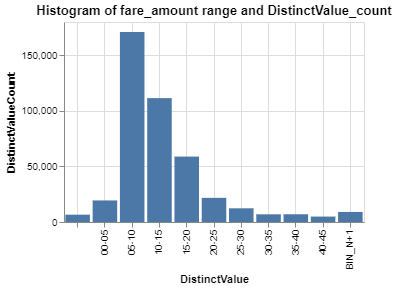

In [39]:
%chart x=DistinctValue, y=DistinctValueCount, title="Histogram of fare_amount range and DistinctValue_count", width=300

<p style = 'font-size:16px;font-family:Arial'>The above graph shows a better distribution of fare amount.
<br>
<br>
    So in this demonstration, we handled the outliers in the latitude longitude as well as fare_amount. Now this filtered dataset most closely represents the actual data i.e., the rides taken. This dataset can safely be used for further analysis.
</p>

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>8. Cleanup</b>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Work Tables</b></p>
<p style = 'font-size:16px;font-family:Arial'>Cleanup work tables to prevent errors next time. This section drops all the tables created during the demonstration.</p>

In [40]:
DROP TABLE NYC_FULL_T

Success: 21 rows affected

In [41]:
DROP TABLE AllStats_unpivoted;

Success: 17 rows affected

In [42]:
DROP VIEW AllStats_pivoted

Success: 12 rows affected

In [43]:
DROP TABLE fare_amount_minmax;

Success: 17 rows affected

In [44]:
DROP TABLE outlierFitTbl

Success: 25 rows affected

In [45]:
DROP VIEW latlong_no_outliers

Success: 13 rows affected

In [46]:
DROP TABLE fare_amount_range

Success: 18 rows affected

In [47]:
DROP TABLE BinCodeFitTbl

Success: 22 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'> <b>Databases and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial'>The following code will clean up tables and databases created above.</p>

In [48]:
call remove_data('DEMO_NYCTaxi');          -- Takes 10 seconds

Success: 0 rows affected

Success: 0 rows affected

,Message
1,Removed objects related to DEMO_NYCTaxi. That ran for 0:00:03.07


<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2023 Teradata. All Rights Reserved</footer>